```text
使用python解决一个旅行商问题，要求将路径规划函数与绘图函数解耦。先进行路径规划再进行绘图
在大小为a*b的地图中随机生成n个节点,节点生成时不需要考虑参数d。
使用边长为d的六边形呈蜂窝状覆盖地图，在GUI界面中绘制蜂窝图以及节点，找到并使用其他颜色绘制含有节点的区域。
路径规划算法应以六边形为单位，旅行商从(0,0)所在的六边形出发，到(a,b)所在的六边形结束。每次行动从当前六边形中心前往相邻的六个六边形中心之一，每个单位可以被访多次，使路径最短。
将算法模块化为一个函数，输入参数包括：(地图长宽a、b，节点个数n，六边形边长d)，以及节点列表，输出路径列表。
在得到路径列表后，生成路径并绘制。
```

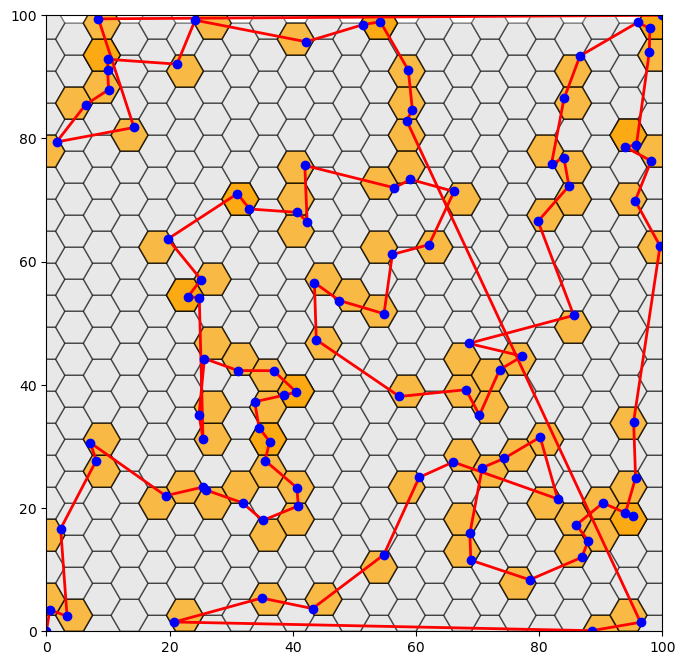

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from scipy.spatial import distance

def hexagon_center_grid(a, b, d):
    """
    生成覆盖地图的六边形网格中心点坐标列表
    """
    hex_centers = []
    row = 0
    y_offset = np.sqrt(3) * d / 2
    while row * y_offset < b:
        col = 0
        x_offset = 3 * d
        while col * x_offset < a:
            x = col * x_offset + (0 if row % 2 == 0 else 1.5 * d)
            y = row * y_offset
            if x <= 1.4*a and y <= 1.4*b:
                hex_centers.append((x, y))
            col += 1
        row += 1
    return hex_centers

def draw_hexagons(ax, centers, d, color='lightgrey', edgecolor='black'):
    """
    在地图上绘制六边形网格
    """
    for center in centers:
        hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                         edgecolor=edgecolor, facecolor=color, alpha=0.5)
        ax.add_patch(hexagon)

def generate_random_nodes(a, b, n):
    """
    在地图上随机生成n个节点
    """
    return [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]

def highlight_hexagons_with_nodes(ax, centers, nodes, d):
    """
    突出显示包含节点的六边形区域
    """
    for node in nodes:
        closest_center = min(centers, key=lambda c: distance.euclidean(c, node))
        hexagon = patches.RegularPolygon(closest_center, numVertices=6, radius=d, orientation=np.radians(30),
                                         edgecolor='black', facecolor='orange', alpha=0.7)
        ax.add_patch(hexagon)

def plan_path(a, b, n, d, node_list, hex_centers):
    """
    规划从(0,0)到(a,b)经过所有节点的最短路径
    """
    path = []
    current_position = (0, 0)
    path.append(current_position)

    unvisited_nodes = node_list[:]

    while unvisited_nodes:
        closest_node = min(unvisited_nodes, key=lambda n: distance.euclidean(current_position, n))
        path.append(closest_node)
        unvisited_nodes.remove(closest_node)
        current_position = closest_node

    path.append((a, b))
    return path

def draw_path(ax, path):
    """
    在地图上绘制路径
    """
    x_vals, y_vals = zip(*path)
    ax.plot(x_vals, y_vals, 'r-', linewidth=2)
    ax.plot(x_vals, y_vals, 'bo')  # 绘制路径上的点

def main():
    a, b = 100, 100  # 地图尺寸
    n = 100  # 节点数
    d = 3   # 六边形边长

    hex_centers = hexagon_center_grid(a, b, d)
    nodes = generate_random_nodes(a, b, n)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)
    ax.set_aspect('equal')

    # 绘制六边形网格
    draw_hexagons(ax, hex_centers, d)

    # 突出显示包含节点的六边形
    highlight_hexagons_with_nodes(ax, hex_centers, nodes, d)

    # 规划路径
    path = plan_path(a, b, n, d, nodes, hex_centers)

    # 绘制路径
    draw_path(ax, path)

    plt.show()

if __name__ == "__main__":
    main()


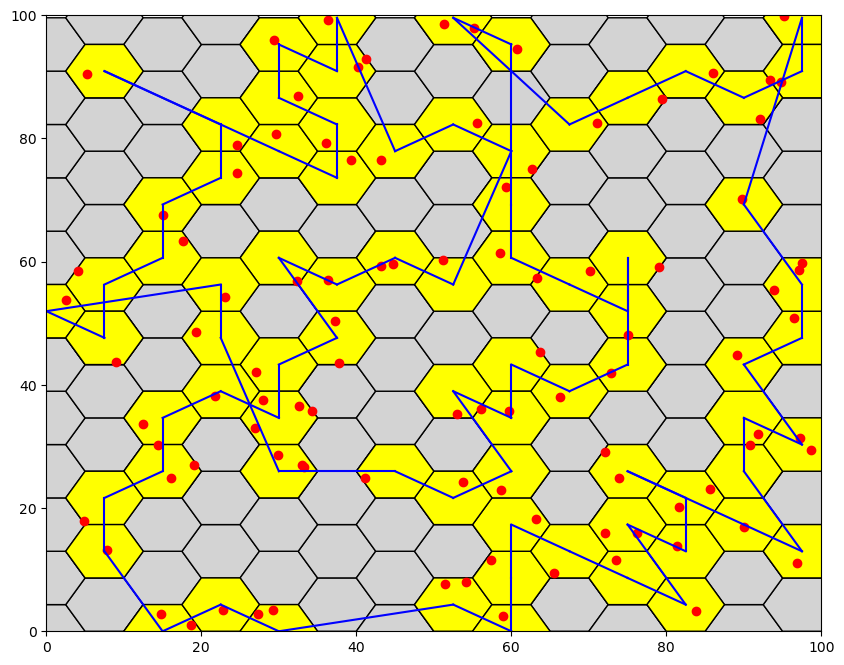

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def hex_distance(p1, p2):
    """Calculate the distance between two hexagons in a hexagonal grid."""
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]), abs(p1[0] + p1[1] - p2[0] - p2[1]))

def generate_hexagonal_grid(a, b, d):
    """Generate the centers of hexagons that cover the map."""
    hex_centers = []
    dx = 3/2 * d
    dy = np.sqrt(3) * d

    for i in range(int(b // dy) + 1):
        for j in range(int(a // dx) + 1):
            cx = j * dx
            cy = i * dy if j % 2 == 0 else i * dy + dy / 2
            hex_centers.append((cx, cy))
    return hex_centers

def find_closest_hexagon(point, hex_centers):
    """Find the closest hexagon center to a given point."""
    return min(hex_centers, key=lambda hex_center: np.hypot(point[0] - hex_center[0], point[1] - hex_center[1]))

def tsp_path_planning(a, b, n, d, nodes):
    """Plan the shortest path that visits all nodes and returns to the start."""
    hex_centers = generate_hexagonal_grid(a, b, d)
    node_hex_centers = [find_closest_hexagon(node, hex_centers) for node in nodes]

    # Create a graph where nodes are hex centers and edges are distances between them
    G = nx.Graph()
    for i, hex1 in enumerate(node_hex_centers):
        for j, hex2 in enumerate(node_hex_centers):
            if i != j:
                G.add_edge(hex1, hex2, weight=hex_distance(hex1, hex2))

    # Find the shortest path using the TSP algorithm
    tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=True)
    return tsp_path, hex_centers

def draw_hexagon(ax, center, d, color='lightgrey'):
    """Draw a single hexagon."""
    hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                     edgecolor='black', facecolor=color)
    ax.add_patch(hexagon)

def draw_tsp_path(a, b, d, tsp_path, hex_centers, nodes):
    """Draw the hexagonal grid, nodes, and the TSP path."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(0, a)
    ax.set_ylim(0, b)

    # Draw hexagonal grid
    for center in hex_centers:
        draw_hexagon(ax, center, d)

    # Highlight hexagons with nodes
    for node_hex in tsp_path:
        draw_hexagon(ax, node_hex, d, color='yellow')

    # Draw nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'ro')

    # Draw path
    for i in range(len(tsp_path) - 1):
        x1, y1 = tsp_path[i]
        x2, y2 = tsp_path[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-')

    plt.show()

def main(a, b, n, d):
    # Generate n random nodes
    nodes = [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]

    # Perform path planning
    tsp_path, hex_centers = tsp_path_planning(a, b, n, d, nodes)

    # Draw the result
    draw_tsp_path(a, b, d, tsp_path, hex_centers, nodes)

# Example parameters
if __name__ == "__main__":
    a = 100
    b = 100
    n = 100
    d = 5

    main(a, b, n, d)


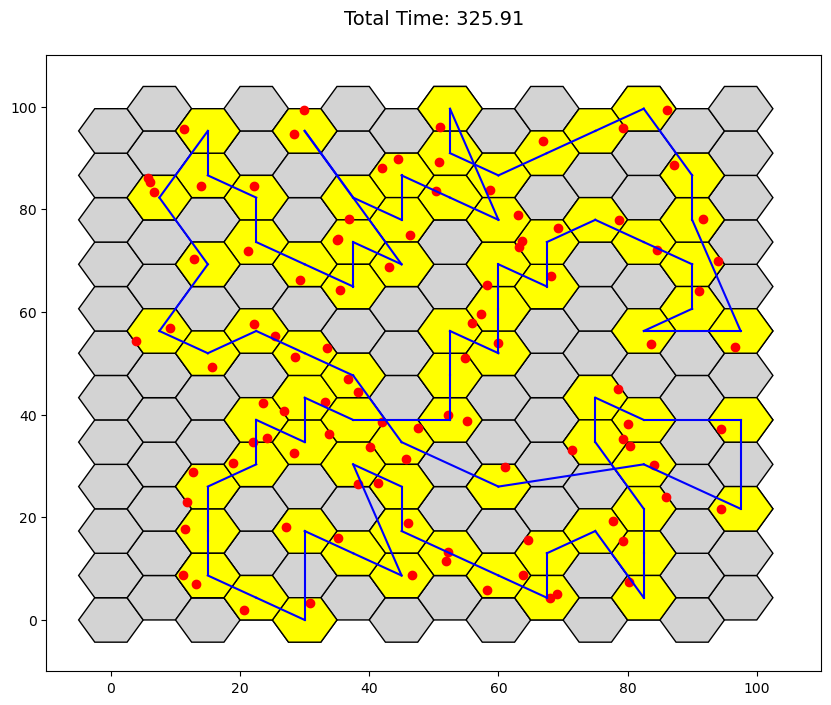

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def hex_distance(p1, p2):
    """Calculate the distance between two hexagons in a hexagonal grid."""
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]), abs(p1[0] + p1[1] - p2[0] - p2[1]))

def generate_hexagonal_grid(a, b, d):
    """Generate the centers of hexagons that cover the map."""
    hex_centers = []
    dx = 3/2 * d
    dy = np.sqrt(3) * d

    for i in range(int(b // dy) + 1):
        for j in range(int(a // dx) + 1):
            cx = j * dx
            cy = i * dy if j % 2 == 0 else i * dy + dy / 2
            hex_centers.append((cx, cy))
    return hex_centers

def find_closest_hexagon(point, hex_centers):
    """Find the closest hexagon center to a given point."""
    return min(hex_centers, key=lambda hex_center: np.hypot(point[0] - hex_center[0], point[1] - hex_center[1]))

def tsp_path_planning(a, b, n, d, nodes, speeds):
    """Plan the shortest path that visits all nodes and returns to the start."""
    hex_centers = generate_hexagonal_grid(a, b, d)
    node_hex_centers = [find_closest_hexagon(node, hex_centers) for node in nodes]

    # Create a graph where nodes are hex centers and edges are distances between them
    G = nx.Graph()
    for i, hex1 in enumerate(node_hex_centers):
        for j, hex2 in enumerate(node_hex_centers):
            if i != j:
                G.add_edge(hex1, hex2, weight=hex_distance(hex1, hex2))

    # Find the shortest path using the TSP algorithm
    tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=True)
    
    # Calculate total time based on variable speeds
    total_time = 0
    for i in range(len(tsp_path) - 1):
        distance = hex_distance(tsp_path[i], tsp_path[i + 1])
        speed = speeds[i]
        total_time += distance / speed
    
    return tsp_path, hex_centers, total_time

def draw_hexagon(ax, center, d, color='lightgrey'):
    """Draw a single hexagon."""
    hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                     edgecolor='black', facecolor=color)
    ax.add_patch(hexagon)

def draw_tsp_path(a, b, d, tsp_path, hex_centers, nodes, total_time):
    """Draw the hexagonal grid, nodes, and the TSP path."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-10, a+10)
    ax.set_ylim(-10, b+10)

    # Draw hexagonal grid
    for center in hex_centers:
        draw_hexagon(ax, center, d)

    # Highlight hexagons with nodes
    for node_hex in tsp_path:
        draw_hexagon(ax, node_hex, d, color='yellow')

    # Draw nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'ro')

    # Draw path
    for i in range(len(tsp_path) - 1):
        x1, y1 = tsp_path[i]
        x2, y2 = tsp_path[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-')
    
    # Display total time as an icon or label
    ax.text(0.5, 1.05, f"Total Time: {total_time:.2f}", transform=ax.transAxes, ha="center", fontsize=14)

    plt.show()

def main(a, b, n, d):
    # Generate n random nodes
    nodes = [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]
    
    # Generate random speeds for each segment
    speeds = [random.uniform(1, 5) for _ in range(n)]

    # Perform path planning
    tsp_path, hex_centers, total_time = tsp_path_planning(a, b, n, d, nodes, speeds)

    # Draw the result
    draw_tsp_path(a, b, d, tsp_path, hex_centers, nodes, total_time)

# Example parameters
if __name__ == "__main__":
    a = 100
    b = 100
    n = 100
    d = 5

    main(a, b, n, d)


```txt
在一片大小为a*b的二维空间中，随机分布着n个点，以坐标原点为中心建立蜂巢网格，六边形边长为d。一个通信范围为d的无人机从原点出发，依次到达每个含有节点的网格的中心，无人机每次仅能从一个网格中心到达此时相邻的网格中心。

功能解耦：主要划分为四个模块：
1.随机生成模块，以不同的方式随机生成多种节点分布。
2.算法模块，依据参数对列表进行排序。
3.评估模块，对得到的结果尽心评估。
4.GUI模块，绘制六边形栅格地图并且对评估结果可视化。

其中GUI模块与其他三个模块隔离，不能阻塞结果的产生，在前三个模块运行结束之后，将结果存入xml文件中，GUI模块启动后读取xml文件来进行展示。
上述三个模块需要封装成库，使用独立的python脚本进行调用，可以重复运算多次，并且对各个模块进行替换。

```

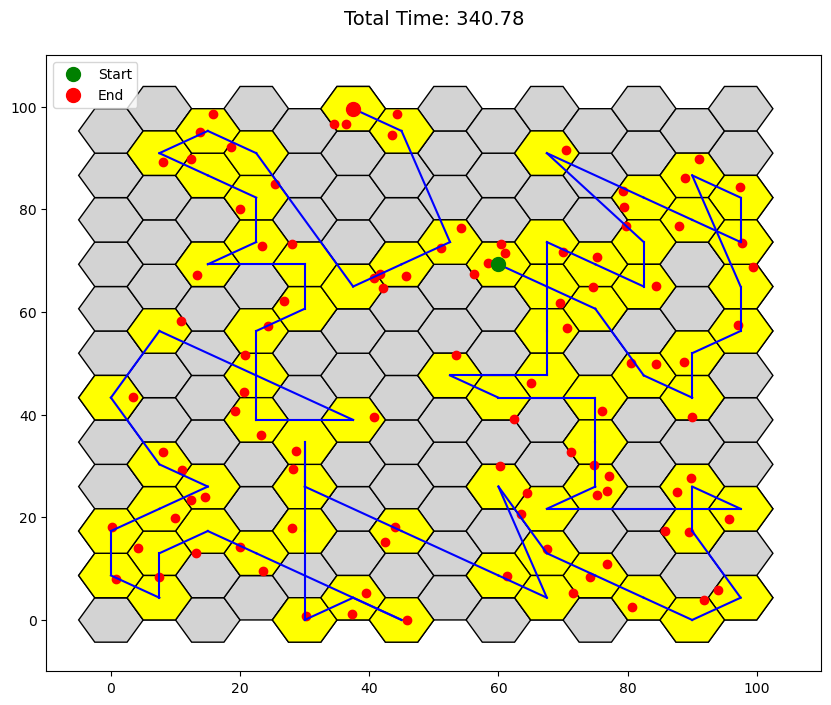

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def hex_distance(p1, p2):
    """Calculate the distance between two hexagons in a hexagonal grid."""
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]), abs(p1[0] + p1[1] - p2[0] - p2[1]))

def generate_hexagonal_grid(a, b, d):
    """Generate the centers of hexagons that cover the map."""
    hex_centers = []
    dx = 3/2 * d
    dy = np.sqrt(3) * d

    for i in range(int(b // dy) + 1):
        for j in range(int(a // dx) + 1):
            cx = j * dx
            cy = i * dy if j % 2 == 0 else i * dy + dy / 2
            hex_centers.append((cx, cy))
    return hex_centers

def find_closest_hexagon(point, hex_centers):
    """Find the closest hexagon center to a given point."""
    return min(hex_centers, key=lambda hex_center: np.hypot(point[0] - hex_center[0], point[1] - hex_center[1]))

def tsp_path_planning(a, b, n, d, nodes, speeds):
    """Plan the path that visits all nodes, starting from the bottom right and ending at the top left."""
    hex_centers = generate_hexagonal_grid(a, b, d)
    node_hex_centers = [find_closest_hexagon(node, hex_centers) for node in nodes]

    # Find start (bottom right) and end (top left) points
    start = max(node_hex_centers, key=lambda p: p[0] + p[1])
    end = min(node_hex_centers, key=lambda p: p[0] + p[1])

    # Create a graph where nodes are hex centers and edges are distances between them
    G = nx.Graph()
    for i, hex1 in enumerate(node_hex_centers):
        for j, hex2 in enumerate(node_hex_centers):
            if i != j:
                G.add_edge(hex1, hex2, weight=hex_distance(hex1, hex2))

    # Find the shortest path using the TSP algorithm, starting and ending at specific points
    path = nx.approximation.traveling_salesman_problem(G, cycle=False, nodes=[start] + [n for n in node_hex_centers if n != start and n != end] + [end])

    # Calculate total time based on variable speeds
    total_time = 0
    for i in range(len(path) - 1):
        distance = hex_distance(path[i], path[i + 1])
        speed = speeds[i]
        total_time += distance / speed

    return path, hex_centers, total_time

def draw_hexagon(ax, center, d, color='lightgrey'):
    """Draw a single hexagon."""
    hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                     edgecolor='black', facecolor=color)
    ax.add_patch(hexagon)

def draw_tsp_path(a, b, d, path, hex_centers, nodes, total_time):
    """Draw the hexagonal grid, nodes, and the path."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-10, a+10)
    ax.set_ylim(-10, b+10)

    # Draw hexagonal grid
    for center in hex_centers:
        draw_hexagon(ax, center, d)

    # Highlight hexagons with nodes
    for node_hex in path:
        draw_hexagon(ax, node_hex, d, color='yellow')

    # Draw nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'ro')

    # Draw path
    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-')

    # Mark start and end points
    start = path[0]
    end = path[-1]
    ax.plot(start[0], start[1], 'go', markersize=10, label='Start')
    ax.plot(end[0], end[1], 'ro', markersize=10, label='End')

    # Display total time as an icon or label
    ax.text(0.5, 1.05, f"Total Time: {total_time:.2f}", transform=ax.transAxes, ha="center", fontsize=14)

    plt.legend()
    plt.show()

def main(a, b, n, d):
    # Generate n random nodes
    nodes = [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]

    # Generate random speeds for each segment
    speeds = [random.uniform(1, 5) for _ in range(n)]

    # Perform path planning
    path, hex_centers, total_time = tsp_path_planning(a, b, n, d, nodes, speeds)

    # Draw the result
    draw_tsp_path(a, b, d, path, hex_centers, nodes, total_time)

# Example parameters
if __name__ == "__main__":
    a = 100  # Width of the area
    b = 100  # Height of the area
    n = 100   # Number of nodes
    d = 5    # Radius of hexagons

    main(a, b, n, d)

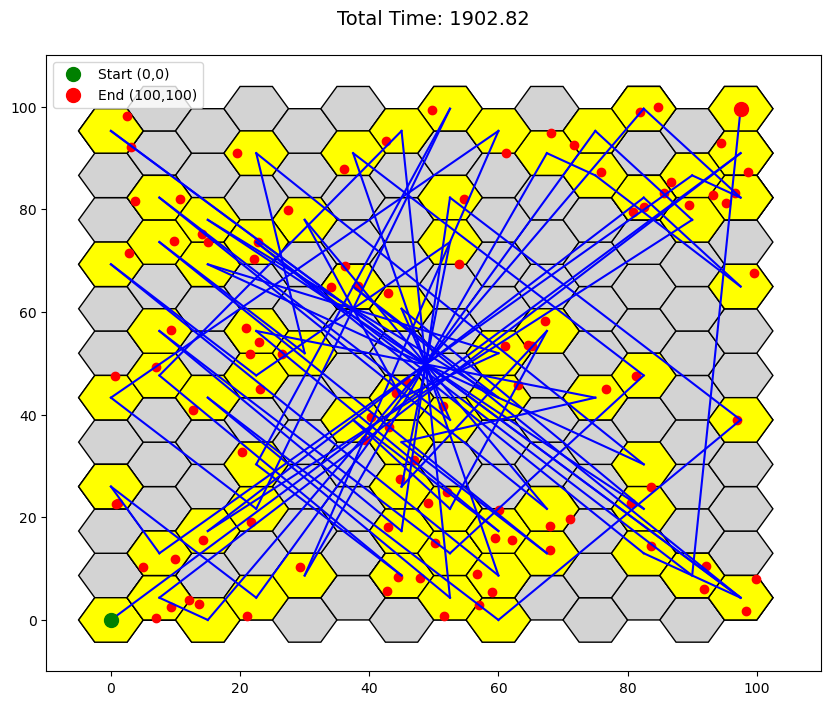

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from functools import lru_cache

def hex_distance(p1, p2):
    """Calculate the distance between two hexagons in a hexagonal grid."""
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]), abs(p1[0] + p1[1] - p2[0] - p2[1]))

@lru_cache(maxsize=None)
def cached_hex_distance(p1, p2):
    """Cached hex distance function to avoid repeated calculations."""
    return hex_distance(p1, p2)

def generate_hexagonal_grid(a, b, d):
    """Generate the centers of hexagons that cover the map."""
    hex_centers = []
    dx = 3/2 * d
    dy = np.sqrt(3) * d

    for i in range(int(b // dy) + 1):
        for j in range(int(a // dx) + 1):
            cx = j * dx
            cy = i * dy if j % 2 == 0 else i * dy + dy / 2
            hex_centers.append((cx, cy))
    return hex_centers

def find_closest_hexagon(point, hex_centers):
    """Find the closest hexagon center to a given point."""
    return min(hex_centers, key=lambda hex_center: np.hypot(point[0] - hex_center[0], point[1] - hex_center[1]))

def optimized_weighted_distance(node, start, end, start_distance, end_distance):
    """Optimized weighted distance function using cached distances."""
    start_weight = 1 - (cached_hex_distance(start, node) / start_distance)
    end_weight = 1 - (cached_hex_distance(node, end) / end_distance)
    return start_weight * end_weight * (cached_hex_distance(start, node) + cached_hex_distance(node, end))

def sort_nodes_with_reference_optimized(nodes, start, end):
    """Optimized sorting function using precomputed distances."""
    start_distance = cached_hex_distance(start, end)
    end_distance = start_distance  # Symmetry: distance between start and end is the same
    return sorted(nodes, key=lambda node: optimized_weighted_distance(node, start, end, start_distance, end_distance))

def tsp_path_planning(a, b, n, d, nodes, speeds):
    """Plan the path that visits all nodes, starting from (0,0) and ending at (a,b)."""
    hex_centers = generate_hexagonal_grid(a, b, d)
    node_hex_centers = [find_closest_hexagon(node, hex_centers) for node in nodes]

    # Find start (0,0) and end (a,b) points
    start = find_closest_hexagon((0, 0), hex_centers)
    end = find_closest_hexagon((a, b), hex_centers)

    # Ensure start and end are in node_hex_centers
    if start not in node_hex_centers:
        node_hex_centers.insert(0, start)
    if end not in node_hex_centers:
        node_hex_centers.append(end)

    # Sort the middle nodes using the optimized weighted sorting function
    sorted_middle_nodes = sort_nodes_with_reference_optimized(node_hex_centers[1:-1], start, end)

    # Combine start, sorted middle nodes, and end
    path = [start] + sorted_middle_nodes + [end]

    # Calculate total time based on variable speeds
    total_time = 0
    for i in range(len(path) - 1):
        distance = hex_distance(path[i], path[i + 1])
        speed = speeds[i % len(speeds)]  # Use modulo to cycle through speeds if necessary
        total_time += distance / speed

    return path, hex_centers, total_time

def draw_hexagon(ax, center, d, color='lightgrey'):
    """Draw a single hexagon."""
    hexagon = patches.RegularPolygon(center, numVertices=6, radius=d, orientation=np.radians(30),
                                     edgecolor='black', facecolor=color)
    ax.add_patch(hexagon)

def draw_tsp_path(a, b, d, path, hex_centers, nodes, total_time):
    """Draw the hexagonal grid, nodes, and the path."""
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xlim(-10, a+10)
    ax.set_ylim(-10, b+10)

    # Draw hexagonal grid
    for center in hex_centers:
        draw_hexagon(ax, center, d)

    # Highlight hexagons with nodes
    for node_hex in path:
        draw_hexagon(ax, node_hex, d, color='yellow')

    # Draw nodes
    for node in nodes:
        ax.plot(node[0], node[1], 'ro')

    # Draw path
    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        ax.plot([x1, x2], [y1, y2], 'b-')

    # Mark start and end points
    start = path[0]
    end = path[-1]
    ax.plot(start[0], start[1], 'go', markersize=10, label='Start (0,0)')
    ax.plot(end[0], end[1], 'ro', markersize=10, label='End (100,100)')

    # Display total time as an icon or label
    ax.text(0.5, 1.05, f"Total Time: {total_time:.2f}", transform=ax.transAxes, ha="center", fontsize=14)

    plt.legend()
    plt.show()

def main(a, b, n, d):
    # Generate n random nodes
    nodes = [(random.uniform(0, a), random.uniform(0, b)) for _ in range(n)]

    # Generate random speeds for each segment
    speeds = [random.uniform(1, 5) for _ in range(n)]

    # Perform path planning
    path, hex_centers, total_time = tsp_path_planning(a, b, n, d, nodes, speeds)

    # Draw the result
    draw_tsp_path(a, b, d, path, hex_centers, nodes, total_time)

# Example parameters
if __name__ == "__main__":
    a = 100  # Width of the area
    b = 100  # Height of the area
    n = 100   # Number of nodes
    d = 5    # Radius of hexagons

    main(a, b, n, d)
